In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings

In [3]:
can_cpi_df = pd.read_csv(r"../data/raw/18100004.csv")
can_cpi_df['REF_DATE'] = pd.to_datetime(can_cpi_df['REF_DATE'])
can_cpi_df = can_cpi_df[(can_cpi_df['REF_DATE'].dt.year >= 2016) & (can_cpi_df['REF_DATE'].dt.year < 2020)]
can_cpi_df = can_cpi_df[can_cpi_df['GEO'] == 'Canada']
can_cpi_df.head()

/var/folders/t8/6bysc4l55cn05grw21ffck1w0000gn/T/ipykernel_69372/1954868832.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  can_cpi_df = pd.read_csv(r"../data/raw/18100004.csv")


,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
893670,2016-01-01,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,126.8,NaN,NaN,NaN,1
893671,2016-01-01,Canada,2016A000011124,Food,2002=100,17,units,0,v41690974,2.3,144.6,NaN,NaN,NaN,1
893672,2016-01-01,Canada,2016A000011124,Food purchased from stores,2002=100,17,units,0,v41690975,2.4,146.1,NaN,NaN,NaN,1
893673,2016-01-01,Canada,2016A000011124,Meat,2002=100,17,units,0,v41690976,2.5,156.9,NaN,NaN,NaN,1
893674,2016-01-01,Canada,2016A000011124,Fresh or frozen meat (excluding poultry),2002=100,17,units,0,v41690977,2.6,169.6,NaN,NaN,NaN,1


In [4]:
warnings.filterwarnings("ignore", message="kurtosis", category=UserWarning)

In [5]:
#First six rows are unneeded meta data describing other things
mapping_df = pd.read_csv(r"../data/raw/18100004_MetaData.csv", skiprows=6)

#first 29 rows are related to provinces and locations which we are not interested in
mapping_df = mapping_df.iloc[29:].reset_index(drop=True)
#final df has the member_id and the parent_id which I can use to map each group to it's overall category

mapping_df.drop(columns=['Member Notes', 'Member Definitions', 'Classification Code', 'Terminated'], inplace=True)

mapping_df['Member ID'] = pd.to_numeric(mapping_df['Member ID'], errors='coerce').astype('Int64')  # Use 'Int64' to preserve NaNs
mapping_df['Parent Member ID'] = pd.to_numeric(mapping_df['Parent Member ID'], errors='coerce').astype('Int64')  # Use 'Int64' to preserve NaNs

mapping_df.head()

,Dimension ID,Member Name,Member ID,Parent Member ID
0,1,Canada,2,<NA>
1,2,"Recreation, education and reading",219,2
2,2,"Alcoholic beverages, tobacco products and recr...",256,2
3,2,Food,3,2
4,2,Shelter,79,2


In [ ]:
# Get the list of unique groups that only map back to the Canadian CPI
base_cpi_categories = mapping_df.loc[mapping_df['Parent Member ID'] == 2, ('Member Name', 'Member ID')]
base_cpi_categories.sort_values(by='Member ID', inplace=True)
print(len(base_cpi_categories))
base_names = base_cpi_categories['Member Name'].to_list()
base_names.append('All-items')
base_names

8


['Food',
 'Shelter',
 'Household operations, furnishings and equipment',
 'Clothing and footwear',
 'Transportation',
 'Health and personal care',
 'Recreation, education and reading',
 'Alcoholic beverages, tobacco products and recreational cannabis',
 'All-items']

In [ ]:
all_can_cpi = can_cpi_df[can_cpi_df['Products and product groups'].isin(base_names)]
all_can_cpi.tail()

,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
991260,2019-12-01,Canada,2016A000011124,Clothing and footwear,2002=100,17,units,0,v41691108,2.139,95.3,NaN,NaN,NaN,1
991281,2019-12-01,Canada,2016A000011124,Transportation,2002=100,17,units,0,v41691128,2.176,143.1,NaN,NaN,NaN,1
991308,2019-12-01,Canada,2016A000011124,Health and personal care,2002=100,17,units,0,v41691153,2.201,127.9,NaN,NaN,NaN,1
991334,2019-12-01,Canada,2016A000011124,"Recreation, education and reading",2002=100,17,units,0,v41691170,2.219,113.2,NaN,NaN,NaN,1
991370,2019-12-01,Canada,2016A000011124,"Alcoholic beverages, tobacco products and recr...",2002=100,17,units,0,v41691206,2.256,170.0,NaN,NaN,NaN,1


In [ ]:
pivoted_can_df = all_can_cpi.pivot(index='REF_DATE', columns='Products and product groups', values='VALUE')
pivoted_can_df['REF_DATE'] = pd.to_datetime(pivoted_can_df.index)
pivoted_can_df.head()

Products and product groups,"Alcoholic beverages, tobacco products and recreational cannabis",All-items,Clothing and footwear,Food,Health and personal care,"Household operations, furnishings and equipment","Recreation, education and reading",Shelter,Transportation,REF_DATE
REF_DATE,,,,,,,,,,
2016-01-01,154.5,126.8,90.8,144.6,121.5,120.0,107.9,134.6,125.1,2016-01-01
2016-02-01,155.2,127.1,92.1,145.0,121.5,121.0,109.6,134.7,123.7,2016-02-01
2016-03-01,156.2,127.9,96.0,144.5,121.4,121.4,110.9,134.8,125.3,2016-03-01
2016-04-01,156.5,128.3,96.0,143.8,122.2,121.6,110.3,134.9,127.8,2016-04-01
2016-05-01,156.8,128.8,96.0,143.3,122.3,122.1,111.7,135.1,129.4,2016-05-01


In [ ]:
def fit_regression(x, y):
    X = sm.add_constant(x)  # Add intercept
    model = sm.OLS(y, X).fit()
    return model

In [ ]:
def plot_regressions(df_before, df_after, category, date, r2_before, r2_after):
    plt.figure(figsize=(10, 6))
    date = pd.to_datetime(date)

    slope_before = df_before['Slope'].iloc[0]  # The slope is the second coefficient (index 1)
    slope_after = df_after['Slope'].iloc[0]

    # Plot the regression lines for the before and after periods
    plt.plot(df_before['REF_DATE'], df_before['y_pred'], label=f'Pre-Tariff', color='blue', linewidth=2)
    plt.plot(df_after['REF_DATE'], df_after['y_pred'], label=f'Post-Tariff', color='red', linewidth=2)

    # Add original data points for context
    plt.scatter(df_before['REF_DATE'], df_before[category], color='blue', alpha=0.5, label=f'Pre-Tariff (Actual)', s=20)
    plt.scatter(df_after['REF_DATE'], df_after[category], color='red', alpha=0.5, label=f'Post-Tariff (Actual)', s=20)
    plt.axvline(x=date, color='gray', linestyle='--', label=f'Tariff Implementation: {date.strftime("%Y-%m-%d")}')

    plt.annotate(f'Slope (Before): {slope_before:.2f}',
                 xy=(1.05, 0.90),
                 xycoords='axes fraction',
                 fontsize=12,
                 color='blue',
                 bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))

    plt.annotate(f'Slope (After): {slope_after:.2f}',
                 xy=(1.05, 0.8),
                 xycoords='axes fraction',
                 fontsize=12,
                 color='red',
                 bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))

    plt.annotate(f'R² (Before): {r2_before:.3f}',
                 xy=(1.05, 0.7),
                 xycoords='axes fraction',
                 fontsize=12,
                 color='blue',
                 bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))

    plt.annotate(f'R² (After): {r2_after:.3f}',
                 xy=(1.05, 0.6),
                 xycoords='axes fraction',
                 fontsize=12,
                 color='red',
                 bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel(category)
    plt.title(f'Regression Before and After Tariff Implementation: {category}')
    plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0), borderaxespad=0.)
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

In [ ]:
def before_after_regression(df, category, date):
    df_before = df.loc[df['REF_DATE'] <= date].copy()
    df_after = df.loc[df['REF_DATE'] >= date].copy()
    #print(f"Number of observations before tariff date: {len(df_before)}, number of observations after: {len(df_after)}")

    model_before = fit_regression(df_before['REF_DATE'].map(pd.Timestamp.toordinal), df_before[category])
    model_after = fit_regression(df_after['REF_DATE'].map(pd.Timestamp.toordinal), df_after[category])

    df_before['y_pred'] = model_before.predict(sm.add_constant(df_before['REF_DATE'].map(pd.Timestamp.toordinal)))
    df_after['y_pred'] = model_after.predict(sm.add_constant(df_after['REF_DATE'].map(pd.Timestamp.toordinal)))

    df_before['Slope'] = model_before.params['REF_DATE'] * 883 #slope is a daily change but this changes it to a amount of change over the course of the time period
    df_after['Slope'] = model_after.params['REF_DATE'] * 549

    r2_before = model_before.rsquared
    r2_after = model_after.rsquared

    # Plot the regressions
    plot_regressions(df_before, df_after, category, date, r2_before, r2_after)

    return model_before, model_before.summary(), model_after, model_after.summary(), model_before.params, model_after.params

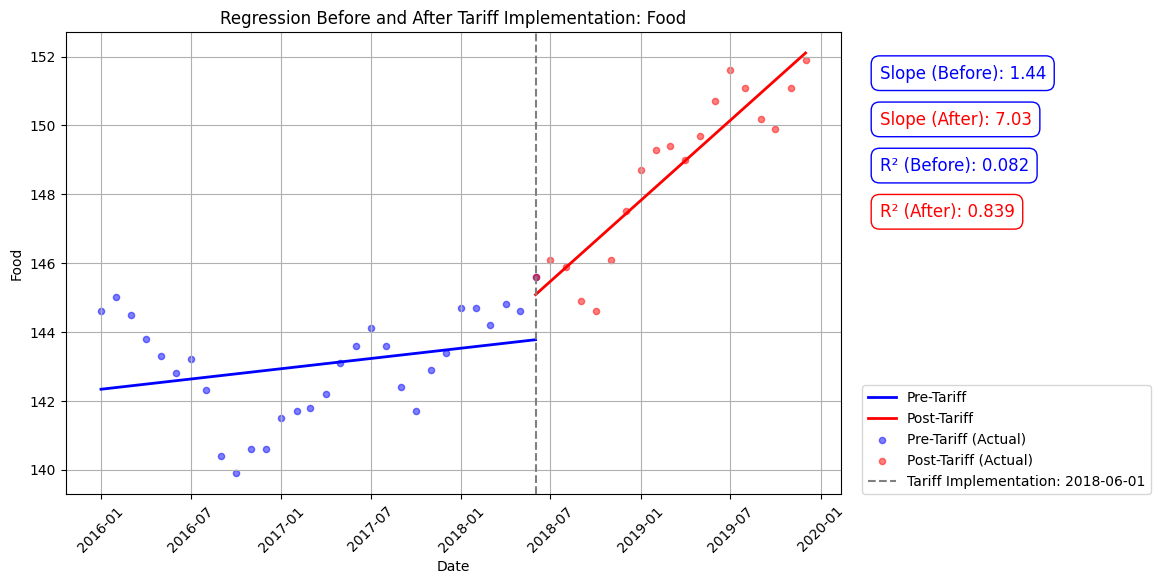

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


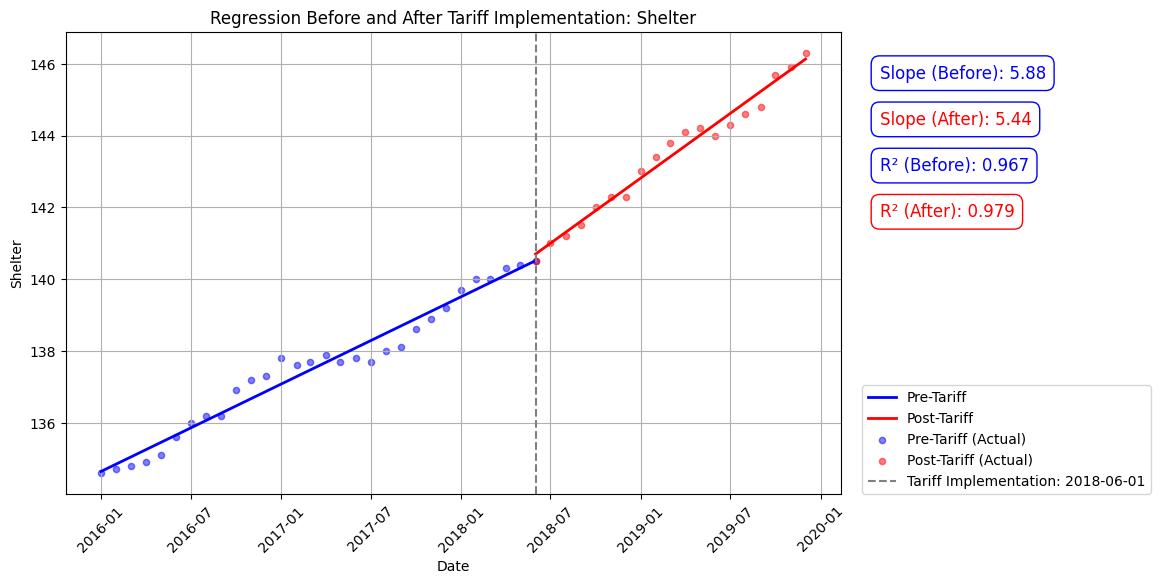

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


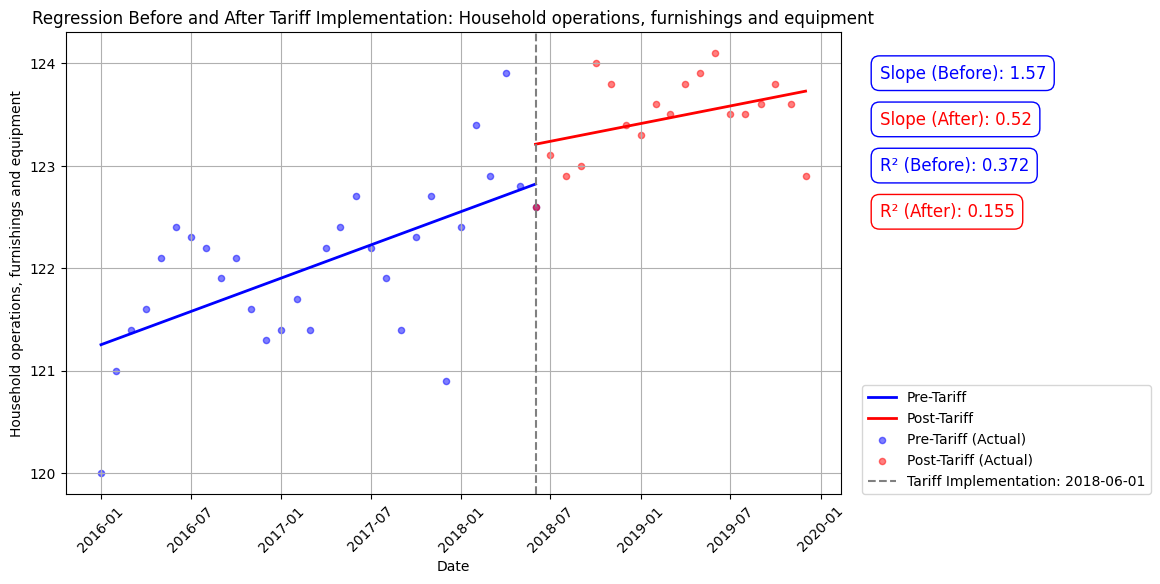

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


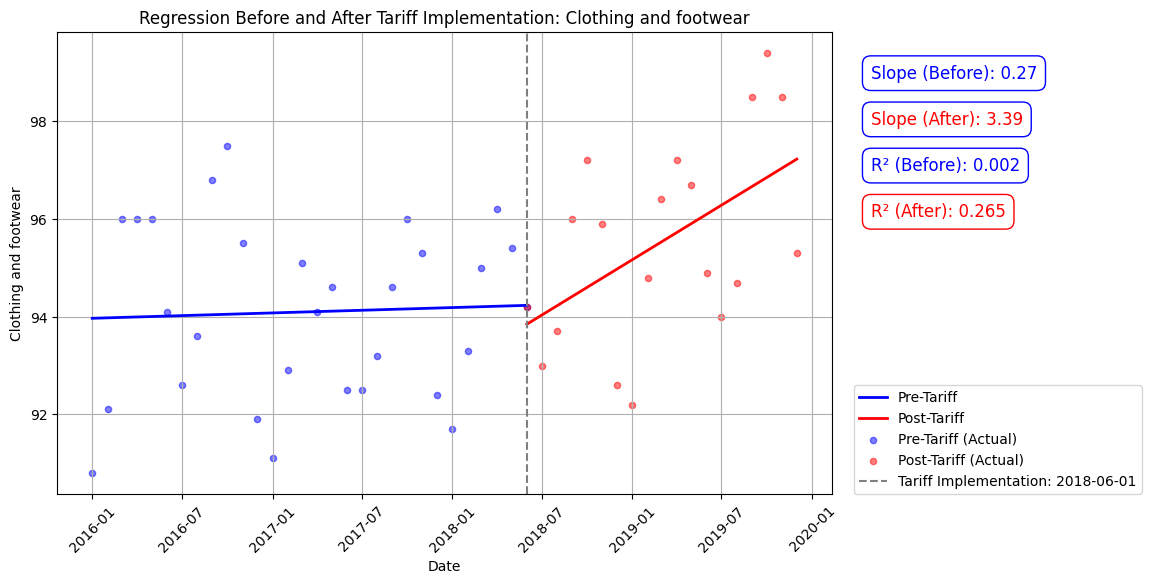

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


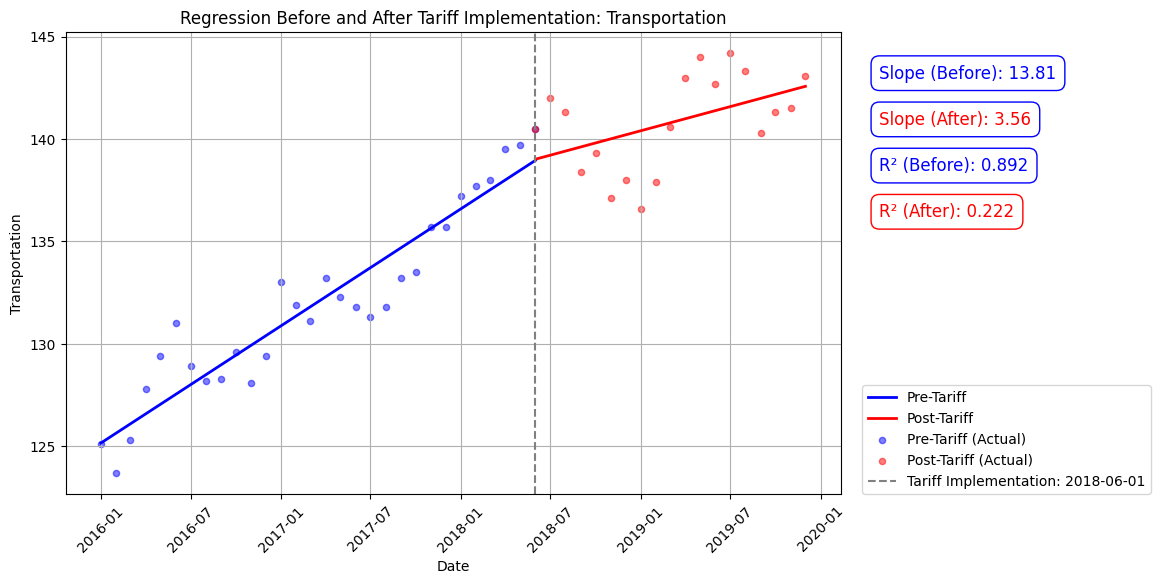

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


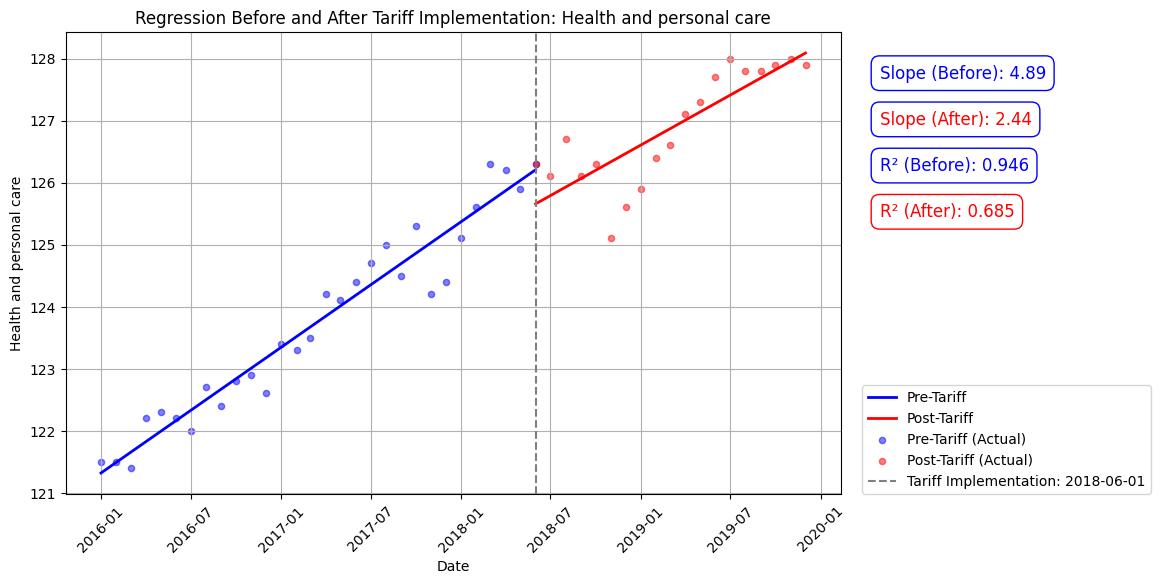

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


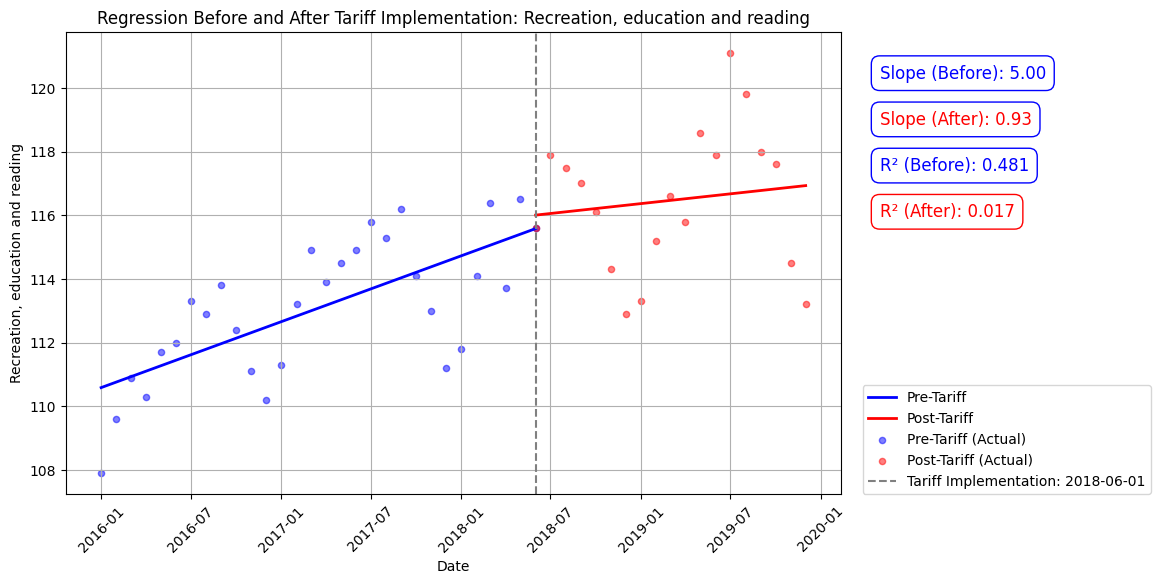

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


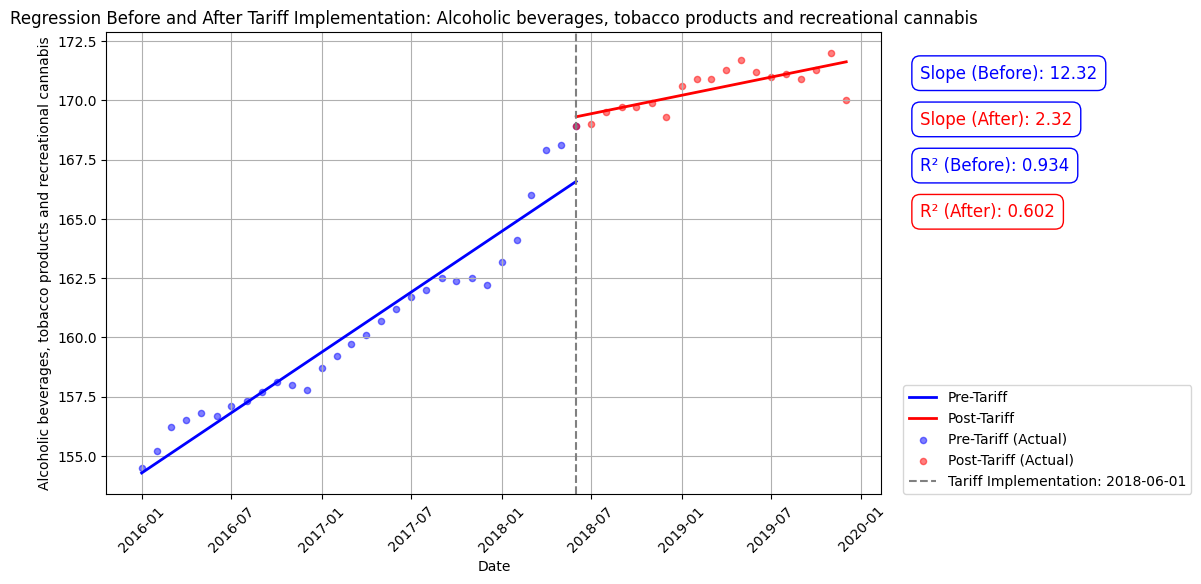

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


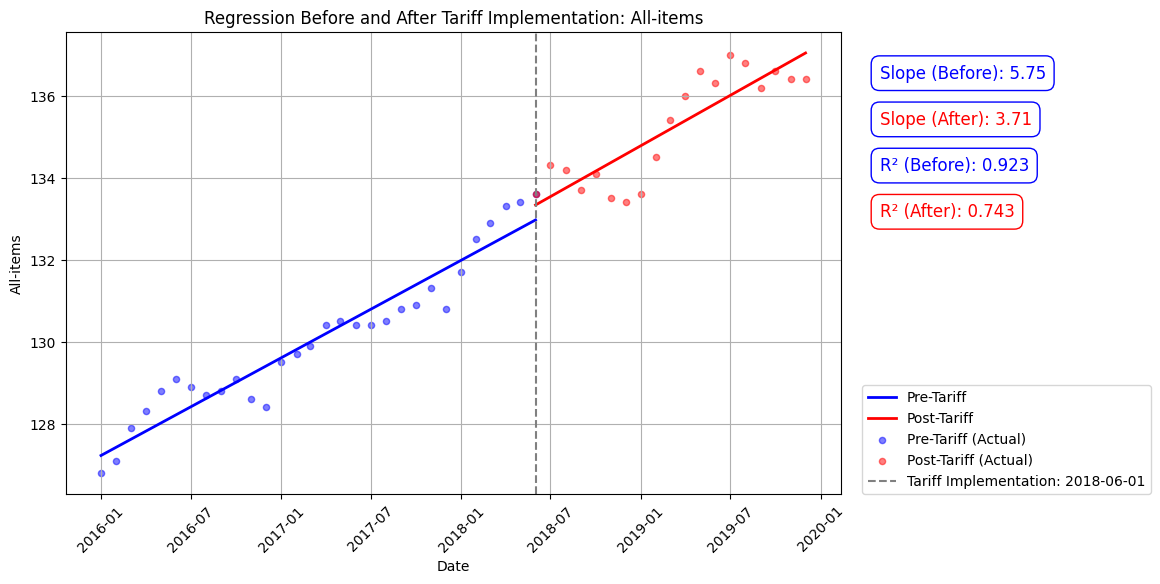

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
for i in base_names:
    before_after_regression(pivoted_can_df, i, '2018-06-01')
